In [1]:
!pip install catboost

     |████████████████████████████████| 76.4 MB 40 kB/s 


In [2]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 403 kB/s 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [4]:
cd drive/MyDrive/Dacon_Credit/

/content/drive/MyDrive/Dacon_Credit


In [5]:
train = pd.read_csv('/content/drive/MyDrive/Dacon_Credit/train.csv')
train.fillna('NAN',inplace=True)

test = pd.read_csv('/content/drive/MyDrive/Dacon_Credit/test.csv')
test.fillna('NAN',inplace=True)

submit = pd.read_csv('/content/drive/MyDrive/Dacon_Credit/sample_submission.csv')

In [6]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)



In [7]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

In [8]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [9]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  18
Number of Categorical features:  9


In [10]:
print(numerical_feats)

print(categorical_feats)

['income_total', 'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'before_EMPLOYED', 'income_total_befofeEMP_ratio', 'before_EMPLOYED_m', 'before_EMPLOYED_w', 'Age', 'DAYS_BIRTH_m', 'DAYS_BIRTH_w', 'EMPLOYED', 'DAYS_EMPLOYED_m', 'DAYS_EMPLOYED_w', 'ability', 'income_mean']
['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']


In [11]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

In [12]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [13]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

In [14]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [15]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [16]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0355842	test: 1.0341201	best: 1.0341201 (0)	total: 71.2ms	remaining: 1m 11s
100:	learn: 0.7041825	test: 0.6430911	best: 0.6430911 (100)	total: 5.39s	remaining: 48s
200:	learn: 0.6850867	test: 0.6427786	best: 0.6425052 (142)	total: 11.2s	remaining: 44.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6425051908
bestIteration = 142

Shrink model to first 143 iterations.
CV Log Loss Score: 0.642505

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0354948	test: 1.0347351	best: 1.0347351 (0)	total: 20.9ms	remaining: 20.9s
100:	learn: 0.7030974	test: 0.6730568	best: 0.6730568 (100)	total: 5.16s	remaining: 45.9s
200:	learn: 0.6843545	test: 0.6713030	best: 0.6709559 (162)	total: 11s	remaining: 43.8s
300:	learn: 0.6682137	test: 0.6710502	best: 0.6706729 (241)	total: 16.8s	remaining: 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest

In [17]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

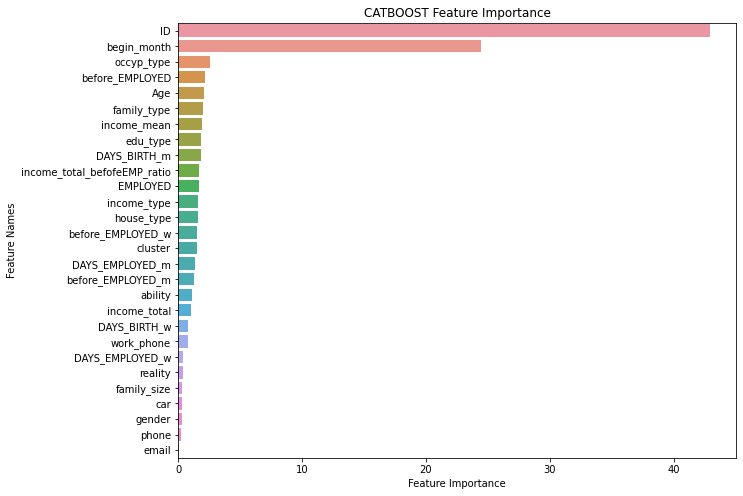

In [18]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')


In [19]:
submit.iloc[:, 1:] = cat_pred_test
submit

,index,0,1,2
0,26457,0.107117,0.175279,0.717603
1,26458,0.342202,0.211986,0.445812
2,26459,0.038135,0.080431,0.881435
3,26460,0.054722,0.078401,0.866877
4,26461,0.085498,0.239725,0.674776
...,...,...,...,...
9995,36452,0.076800,0.219809,0.703391
9996,36453,0.336242,0.176297,0.487461
9997,36454,0.046139,0.105959,0.847901
9998,36455,0.149732,0.305009,0.545260


In [20]:
submit.to_csv('submission0523_Final.csv', index=False)